Author: Rudi Kreidenhuber, <Rudi.Kreidenhuber@gmail.com>, 
License: BSD (3-clause)

## To do:

grand_average (z.B. EEG_grand_average) --> order of occurence doesn't count right

seizure superimposed is not working properly - maybe just drop it from pipeline?
plot_interactive should become exactly that :-)

Marker i- ---> ignore
Summary statistics (Number of occurences of Semio-Markers, EEG-Markers, ..., EKG?)


----

# Video EEG Monitoring Annotation visualizer

----


## Inputs:
 - .edf-files you wish to analyze go into ./data folder

## Run:
 - Press play :-)

## Outputs:
 - Found in results folder
 - Results for single files are put into a folder that matches the input-filename

----

## Howto:
 1. **Mark Events in EEG file using the following prefixes:**
 - e- --> EEG marker
 - s- --> Semiology marker
 - no prefix --> Everything else (clinical tests during/ after seizure)
 - i- --> Marker to ignore for focused analysis

 - One marker **must (!) contain "Beginn"** --> this is considered the seizure onset (if it is missing, onset is set to zero)
 - every marker **can** contain Beginn, for example:
 - Onset first seen in EEG --> Markername "e-asdBeginnfgh" --> would still be recognized as EEG marker and seizure onset
 2. **Save EEG file in .edf format and copy to ./data folder**
 - Every file in this folder is going to be analyzed, if it ends with .edf
 

----
## Configuration
----

### Parameters:
graph_sep_line_width
- How far blue dashed seperator lines are apart from each other

plot_tmin
- First time point in seconds from onset, that should be included in the visualization, set to 0 to deactivate

plot_tmax
- Last time point in seconds from onset, that should be included in the visualization, set to 0 to deactivate


In [1]:
graph_sep_line_width = 5
plot_tmin = 5
plot_tmax = 60

----
## Pipeline start
----

In [2]:
# import everything
import os
import glob
import mne
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from utils import (get_parent_dir, extract_lab_sec, loc_of_sep_lines, plot_seizure_horizontal, plot_seizure_vertical,
                                        raw_to_df, extract_groups, extract_ordered_groups, save_plotly_to_html,
                                        shrink_df_to_tmax, create_results_folders, save_fig_to_disc, plot_interactive_subplot_with_table)

# no need to show figures here
plt.ioff() 

# grab .edfs
edfs = glob.glob("../data/*.edf")

----
## Static visualization
----

Now processing file: ../data/PC19012021_F1.edf
Extracting EDF parameters from /Users/idrael/git/VEEG_Event_Processor/data/PC19012021_F1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122111  =      0.000 ...   476.996 secs...
Error: No marker containing "Beginn" found, cannot determine seizure onset for file:  ../data/PC19012021_F1.edf
Setting seizure onset to the beginning of the file



Calculating parameters for focused visualization, tmin = 5, tmax = 60 s.



Now processing file: ../data/PC19012021_F3.edf
Extracting EDF parameters from /Users/idrael/git/VEEG_Event_Processor/data/PC19012021_F3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 429055  =      0.000 ...  1675.996 secs...
There are multiple markers for seizure onset in this file --> taking first one.



Calculating parameters for focused visualization, tmin = 5, tmax = 60 s.



Now processing file: ../data/PC19

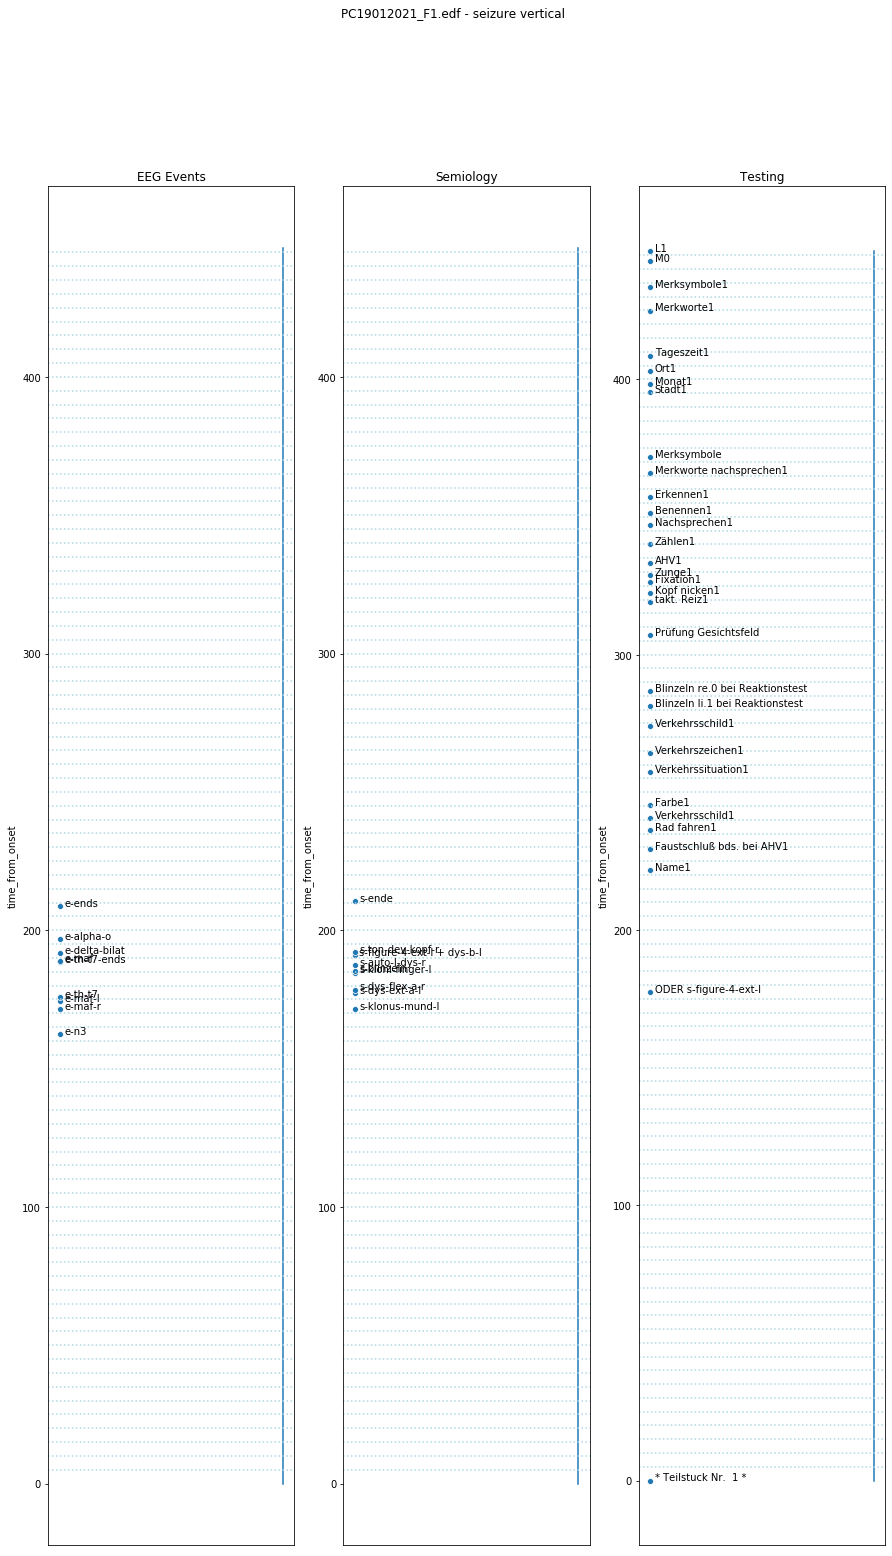

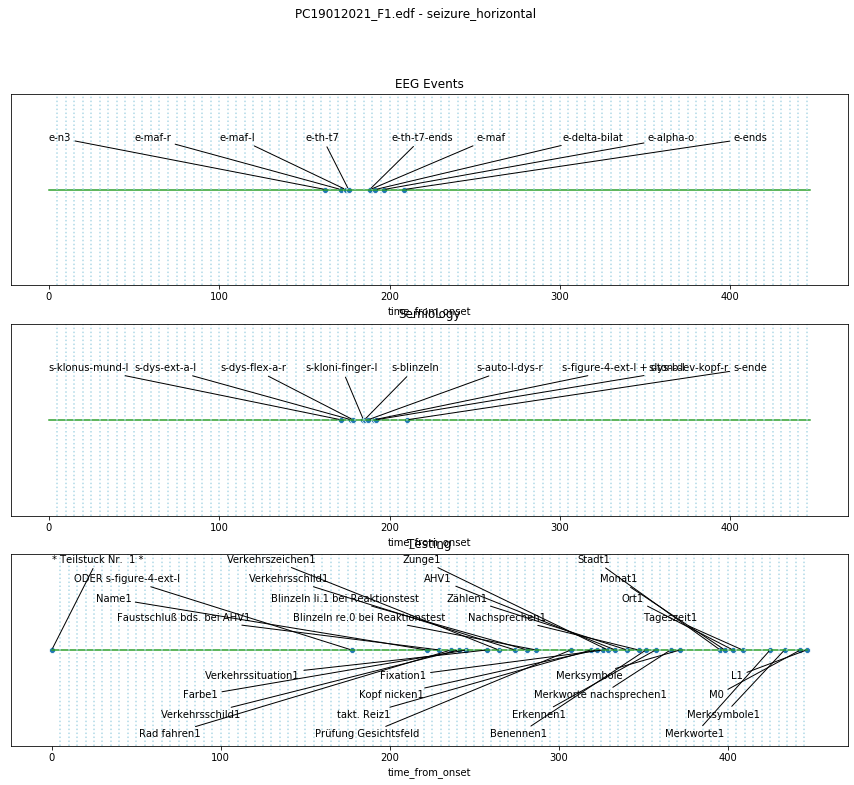

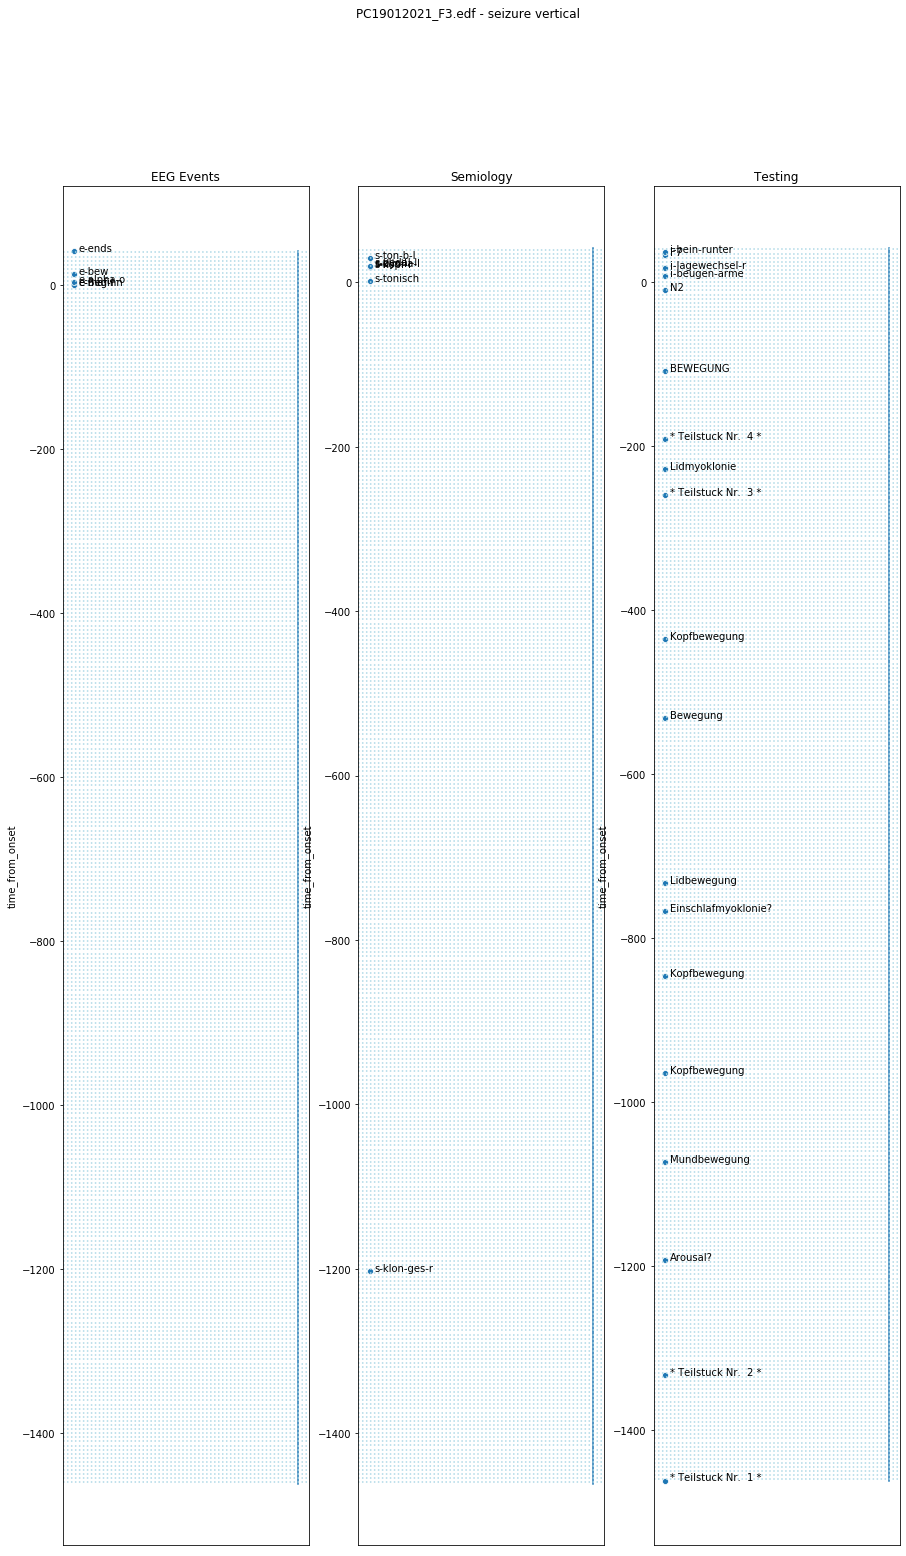

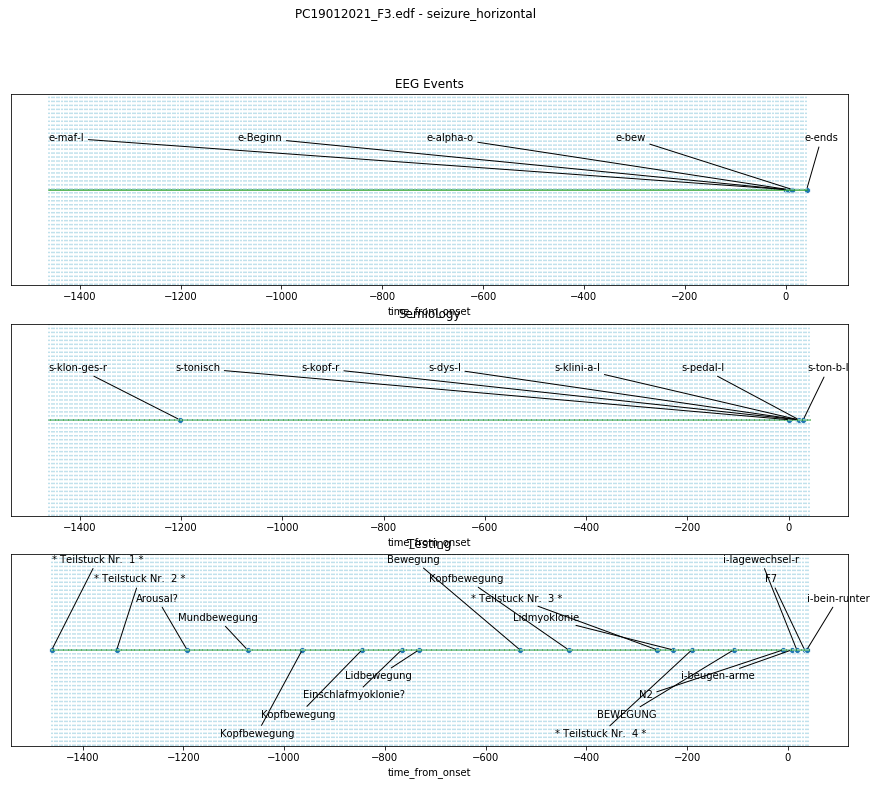

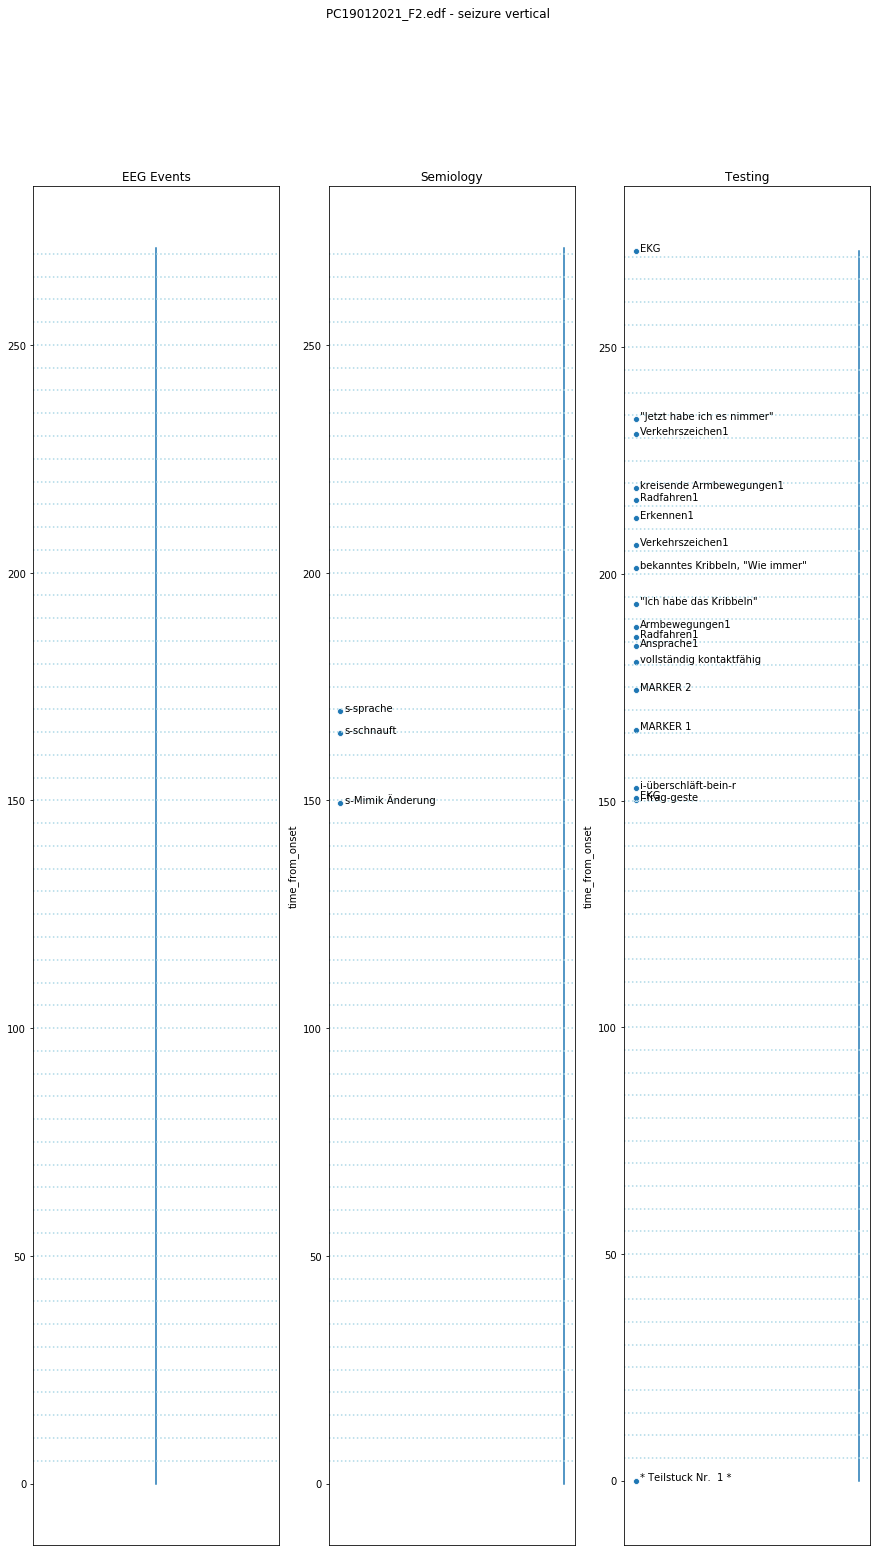

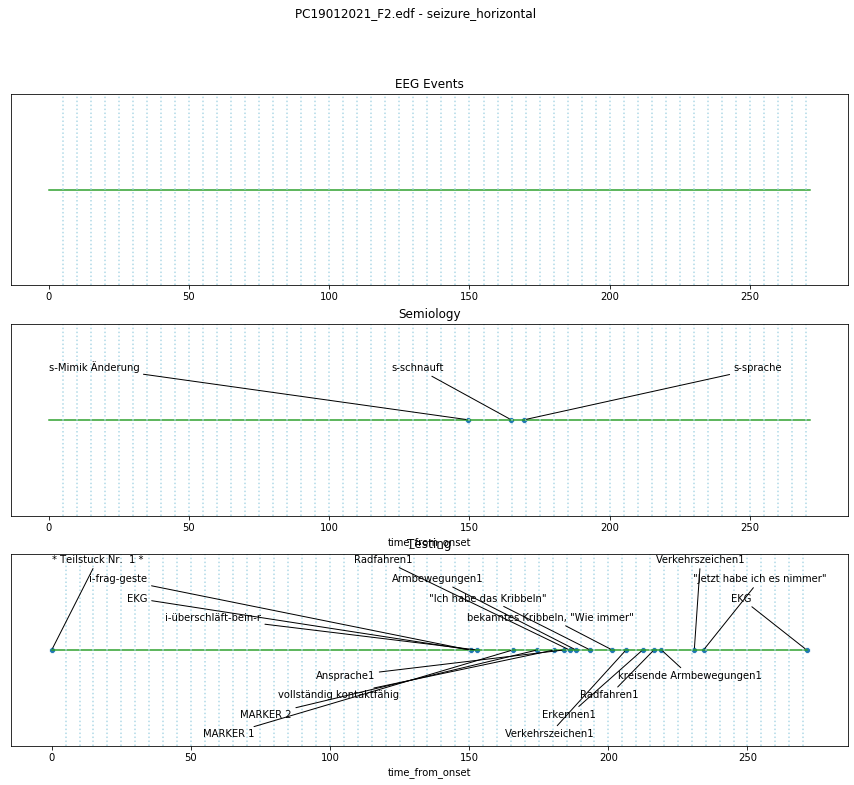

In [3]:
if len(edfs) > 0:
    # Create folder structure
    create_results_folders(edfs)
    df = dict() 
    shrinked_df = dict()
    for e in edfs:
        print(f"Now processing file: {e}")
        raw = mne.io.read_raw(e, preload=True)                      #read
        df[e] = raw_to_df(raw, e)                                   # annotations to DataFrame
        e_events, s_events, t_events = extract_groups(df[e], e)     # Extract groups

        
        # Shrink df to tmax
        if plot_tmax != 0 or plot_tmin != 0:
            print(f"\nCalculating parameters for focused visualization, tmin = {plot_tmin}, tmax = {plot_tmax} s.\n\n\n")
            if df[e].iloc[0,0] != []:
                shrinked_df[e] = shrink_df_to_tmax(df=df[e], tmax=plot_tmax, tmin=plot_tmin)
                se_events, ss_events, st_events = extract_groups(shrinked_df[e], e)
    
        # Visualizations
                seizure_vertical_w_limits = plot_seizure_vertical(df=shrinked_df[e], eeg=se_events, 
                                                                    semio=ss_events, testing=st_events, 
                                                                    source=e.split("/")[-1], tmin= plot_tmin, 
                                                                    tmax=plot_tmax, name="seizure vertical with time limits",
                                                                    graph_sep_line_width=graph_sep_line_width)
                save_fig_to_disc(seizure_vertical_w_limits, e, "seizure_vertical_w_limits")

                seizure_horizontal_w_limits = plot_seizure_horizontal(df=shrinked_df[e], eeg=se_events, 
                                                                    semio=ss_events, testing=st_events, 
                                                                    source=e.split("/")[-1], tmin= plot_tmin, 
                                                                    tmax=plot_tmax, name="seizure horizontal with time limits",
                                                                    graph_sep_line_width=graph_sep_line_width)
                save_fig_to_disc(seizure_horizontal_w_limits, e, "seizure_horizontal_w_limits")


        seizure_vertical = plot_seizure_vertical(df=df[e], eeg=e_events, semio=s_events, 
                                                    testing=t_events, source=e.split("/")[-1], 
                                                    name="seizure vertical",
                                                    graph_sep_line_width=graph_sep_line_width)
        save_fig_to_disc(seizure_vertical, e, "seizure_vertical")

        seizure_horizontal = plot_seizure_horizontal(df=df[e], eeg=e_events, semio=s_events, 
                                                    testing=t_events, source=e.split("/")[-1], 
                                                    name="seizure_horizontal",
                                                    graph_sep_line_width=graph_sep_line_width)
        save_fig_to_disc(seizure_horizontal, e, "seizure_horizontal")

----
## Save data
----

In [4]:
if len(edfs) > 0:
    # Create folder structure
    create_results_folders(edfs)
    df = dict()
    shrinked_df = dict()
    for e in edfs:
        raw = mne.io.read_raw(e, preload=True)                      #read
        df[e] = raw_to_df(raw, e)                                   # annotations to DataFrame
        e_events, s_events, t_events = extract_groups(df[e], e)     # Extract groups
        #save
        source = e.split("/")[-1].split(".")[0]
        save_path = ("../results/" + source + "/" + "tables/All_events.tsv")
        df[e].to_csv(save_path, sep="\t")
        save_path = ("../results/" + source + "/" + "tables/EEG_events.tsv")
        e_events.to_csv(save_path, sep="\t")
        save_path = ("../results/" + source + "/" + "tables/Semiology_events.tsv")
        s_events.to_csv(save_path, sep="\t")
        save_path = ("../results/" + source + "/" + "tables/Test_events.tsv")
        t_events.to_csv(save_path, sep="\t")

# Vertical grand average
df_keys = df.keys()
for idx, val in enumerate(df_keys):
    if idx == 0:
        concat = df[val]
        concat.insert(loc=0, column='source', value=val.split("/")[-1])
        #concat["source"] = val
        print(concat)
        
    if idx > 0:
        new_df = df[val]
        new_df.insert(loc=0, column='source', value=val.split("/")[-1])
        concat = pd.concat([concat, new_df], axis=0)     
    idx += 1
concat.drop(columns=["onset"], axis=1)
concat = concat.sort_values(by=["time_from_onset"])
concat.to_csv("../results/grand_average/tables/All_events.tsv", sep="\t")

# horizontal grand average
for idx, val in enumerate(df_keys):
    if idx == 0:
        concat = df[val]
        cols = list(concat)
        cols.insert(0, cols.pop(cols.index('source')))
        concat = concat.loc[:, cols]
        concat = concat.sort_values(by=["time_from_onset"])
        concat = concat.drop(columns=["onset"], axis=1)
        concat["order_of_occurence"] = (1 + np.arange(len(concat.loc[:,"time_from_onset"])))
        
    if idx > 0:
        new_df = df[val]
        cols = list(new_df)
        cols.insert(0, cols.pop(cols.index('source')))
        new_df = new_df.loc[:, cols]
        new_df.drop(columns=["onset"], axis=1, inplace=True)
        new_df["order_of_occurence"] = (1 + np.arange(len(new_df.loc[:,"time_from_onset"])))
        concat = pd.merge(concat, new_df, how="outer", on="description", suffixes=(" ", "  "))
    print(f"\n\n\n\nRun {idx} --> concat = {concat}")
    idx += 1

concat.to_csv("../results/grand_average//tables/All_Data_horizontal.tsv", sep="\t")

EEG_grand_average, Semio_grand_average, Test_grand_average = extract_ordered_groups(concat)
EEG_grand_average.to_csv("../results/grand_average//tables/EEG_events_grand_average.tsv", sep="\t")
Semio_grand_average.to_csv("../results/grand_average//tables/Semiology_events_grand_average.tsv", sep="\t")
Test_grand_average.to_csv("../results/grand_average//tables/Test_events_grand_average.tsv", sep="\t")

Extracting EDF parameters from /Users/idrael/git/VEEG_Event_Processor/data/PC19012021_F1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 122111  =      0.000 ...   476.996 secs...
Error: No marker containing "Beginn" found, cannot determine seizure onset for file:  ../data/PC19012021_F1.edf
Setting seizure onset to the beginning of the file
Extracting EDF parameters from /Users/idrael/git/VEEG_Event_Processor/data/PC19012021_F3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 429055  =      0.000 ...  1675.996 secs...
There are multiple markers for seizure onset in this file --> taking first one.
Extracting EDF parameters from /Users/idrael/git/VEEG_Event_Processor/data/PC19012021_F2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 85247  =      0.000 ...   332.996 secs...
Error: No marker containing "Beginn" found, cannot

----
# Interactive Visualization
----

ga_df=pd.read_csv("../results/grand_average/tables/All_events.tsv", sep="\t")
ga_df

def plot_interactive_subplots(df=None, eeg=None, semio=None, testing=None, title=None):
    xaxis_title="Time in seconds (from seizure onset)"
    fig = make_subplots(rows=4, cols=1, shared_xaxes="all", 
                        specs=[[{"type": "scatter"}],
                                [{"type": "scatter"}],
                                [{"type": "scatter"}],
                                [{"type": "scatter"}]],
                        subplot_titles=("EEG", "Semiologie", "Testing", "All events"))
    # Add traces
    x_axis = df["time_from_onset"]
    y_axis = np.ones_like(x_axis)
    # eeg
    times, labels = extract_lab_sec(eeg)
    fig.add_trace(go.Scatter(x=times, y=y_axis,
                        mode='markers',                 #mode="markers+text"
                        hoverinfo="name+x+text",
                        name='EEG',
                        text=labels,
                        marker_symbol="diamond"), row=1, col=1)
    # semio
    times, labels = extract_lab_sec(semio)
    fig.add_trace(go.Scatter(x=times, y=y_axis,
                        mode='markers',
                        name='Semiology',
                        text=labels,
                        marker_symbol="x"), row=2, col=1)
    # testing
    times, labels = extract_lab_sec(testing)
    fig.add_trace(go.Scatter(x=times, y=y_axis,
                        mode='markers',
                        name='Testing',
                        text=labels,
                        marker_symbol="circle"), row=3, col=1)
    # grand average
    times, labels = extract_lab_sec(df)
    fig.add_trace(go.Scatter(x=times, y=y_axis,
                        mode='markers',
                        name='All events',
                        text=labels,
                        marker_symbol="hexagon2-open-dot"), row=4, col=1)

    fig.update_layout(title=title, yaxis_title="")
    fig.update_xaxes(rangeslider={"visible":True}, title={"text":xaxis_title}, row=4)
    fig.update_yaxes(visible=False, showticklabels=False)

    # Add range slider
    fig.update_layout(height=500, width=1500)

    fig.show()
    return fig

In [5]:
# Seizure subplots
event_folders = glob.glob("../results/*")
data = dict()
interactive_plots = dict()
for e in event_folders:
    source = e.split("/")[-1]
    tsv = e + "/tables/All_events.tsv"
    data[source] = pd.read_csv(tsv, sep="\t")
    EEG, Semio, Test = extract_ordered_groups(data[source])
    interactive_plots[source] = plot_interactive_subplot_with_table(data[source], EEG, Semio, Test, title=source)
    for s in source:
        save_plotly_to_html(interactive_plots[source], source=source)